In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime

In [2]:
def flatten(obs):
    return torch.tensor(obs.flatten(), dtype=torch.float32)


In [3]:
class A2C_Model(nn.Module):
    def __init__(self, input_dim=42, n_actions=7):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )

        self.policy = nn.Linear(128, n_actions)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

    def act(self, obs, available_actions=None):
        logits, value = self.forward(obs)
        
        # Mask illegal actions
        if available_actions is not None:
            mask = torch.ones(logits.size(-1)) * float('-inf')
            mask[available_actions] = 0
            logits = logits + mask
        
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value

In [4]:
class SelfPlayOpponent:
    """
    Stores older snapshots of the agent and samples from them.
    If empty, plays random.
    """
    def __init__(self):
        self.opponents = []

    def add(self, model_state):
        self.opponents.append(model_state)

    def select_action(self, obs, model_class):
        if len(self.opponents) == 0:
            # Random if no opponent yet
            legal = [i for i in range(7) if obs[0, i] == 0]
            return np.random.choice(legal)

        # Sample a random past model
        snapshot = np.random.choice(self.opponents)
        opponent_model = model_class()
        opponent_model.load_state_dict(snapshot)
        opponent_model.eval()

        obs_flat = flatten(obs)
        logits, _ = opponent_model(obs_flat)
        probs = torch.softmax(logits, dim=-1)
        action = torch.argmax(probs).item()

        # Ensure legal
        legal = [i for i in range(7) if obs[0, i] == 0]
        if action not in legal:
            action = np.random.choice(legal)
        return action


In [ ]:
class Connect4Env:
    def __init__(self, opponent=None):
        self.rows, self.cols = 6, 7
        self.opponent = opponent  
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=np.int8)
        self.done = False
        return self.board.copy()

    def available_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def drop(self, col, player):
        if self.board[0, col] != 0:
            return False
        for r in range(self.rows - 1, -1, -1):
            if self.board[r, col] == 0:
                self.board[r, col] = player
                return True
        return False

    def check_win(self, p):
        b = self.board
        R, C = self.rows, self.cols

        # Horizontal
        for r in range(R):
            for c in range(C - 3):
                if np.all(b[r, c:c + 4] == p):
                    return True

        # Vertical
        for r in range(R - 3):
            for c in range(C):
                if np.all(b[r:r + 4, c] == p):
                    return True

        # Diagonal down-right
        for r in range(R - 3):
            for c in range(C - 3):
                if all(b[r + i, c + i] == p for i in range(4)):
                    return True

        # Diagonal up-right
        for r in range(3, R):
            for c in range(C - 3):
                if all(b[r - i, c + i] == p for i in range(4)):
                    return True

        return False

    def is_draw(self):
        return np.all(self.board != 0)

    def three_in_row(self, p):
        b = self.board
        R, C = self.rows, self.cols
        count = 0

        for r in range(R):
            for c in range(C - 2):
                if np.sum(b[r, c:c+3] == p) == 3:
                    count += 1

        for r in range(R - 2):
            for c in range(C):
                if np.sum(b[r:r+3, c] == p) == 3:
                    count += 1

        for r in range(R - 2):
            for c in range(C - 2):
                if all(b[r + i, c + i] == p for i in range(3)):
                    count += 1

        for r in range(2, R):
            for c in range(C - 2):
                if all(b[r - i, c + i] == p for i in range(3)):
                    count += 1

        return count

    def step(self, action):
        # ----- Agent Move -----
        # Check legality first
        if action not in self.available_actions():
            # Illegal move: penalize and retry (do not end episode, do not let opponent play)
            return self.board.copy(), -0.5, False, {"illegal": True}

        self.drop(action, 1)

        # Shaping: 3-in-a-row
        reward = 0.1 * self.three_in_row(1)
        reward -= 0.1 * self.three_in_row(2)

        # Win?
        if self.check_win(1):
            return self.board.copy(), reward + 1.0, True, {"winner": 1}

        # Draw?
        if self.is_draw():
            return self.board.copy(), reward, True, {"winner": 0}

        # ----- Opponent Move -----
        if self.opponent:
            if isinstance(self.opponent, SelfPlayOpponent):
                opp_action = self.opponent.select_action(self.board.copy(), A2C_Model)
            else:
                # Fallback random
                avail = self.available_actions()
                if not avail: # Should be covered by is_draw, but safety check
                     return self.board.copy(), reward, True, {"winner": 0}
                opp_action = np.random.choice(avail)

            self.drop(opp_action, 2)

            # Opponent shaping
            reward -= 0.1 * self.three_in_row(2)

            # Loss?
            if self.check_win(2):
                return self.board.copy(), reward - 1.0, True, {"winner": 2}

            # Draw?
            if self.is_draw():
                return self.board.copy(), reward, True, {"winner": 0}

        return self.board.copy(), reward, False, {}

In [ ]:
gamma = 0.99
lam = 0.95
lr = 3e-4
entropy_coef = 0.05  # Increase for exploration

In [7]:
def save_checkpoint(model, ep):
    filename = os.path.join(run_dir, f"checkpoint_ep{ep}.pth")
    torch.save(model.state_dict(), filename)
    print(f" Saved checkpoint: {filename}")

def save_best_model(model):
    torch.save(model.state_dict(), BEST_MODEL)
    print(f" New best model saved to {BEST_MODEL}")

def log_to_csv(ep, reward, avg10, best):
    with open(LOG_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([ep, reward, avg10, best])



In [8]:
def compute_gae(rewards, values, dones):
    advantages, gae = [], 0
    
    # Convert all values to detached tensors
    values = [v.detach().item() if hasattr(v, 'detach') else float(v) for v in values]
    values = values + [0.0]

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1-dones[t]) - values[t]
        gae = delta + gamma * lam * (1-dones[t]) * gae
        advantages.insert(0, gae)
    
    returns = [adv + values[i] for i, adv in enumerate(advantages)]
    
    # Convert back to tensors
    return [torch.tensor(a, dtype=torch.float32) for a in advantages], \
           [torch.tensor(r, dtype=torch.float32) for r in returns]

In [9]:
reward_history = [] 
best_avg_reward = -99999

model = A2C_Model()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train_connect4_selfplay(episodes=500, log_interval=10):

    from datetime import datetime
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join("runs", f"connect4_A2C_{run_id}")
    os.makedirs(log_dir, exist_ok=True)
    log_file_path = os.path.join(log_dir, "training_log.csv")

    with open(log_file_path, "w") as f:
        f.write("episode,total_reward,avg_reward_10,best_reward\n")


    opponent_manager = SelfPlayOpponent()
    env = Connect4Env(opponent=opponent_manager)

    reward_history = []
    best_avg_reward = -float("inf")

    for ep in range(episodes):

        obs = env.reset()
        done = False
        ep_reward = 0

        states, actions, logprobs, vals, rewards, dones = [], [], [], [], [], []


        # ====== RUN ONE EPISODE ======
        while not done:
            s = flatten(obs)
            
            a, lp, v = model.act(s)

            states.append(s)
            actions.append(a)
            logprobs.append(lp) 
            vals.append(v)      
            
            obs, r, done, info = env.step(a)
            rewards.append(r)
            dones.append(done)

            ep_reward += r

        
        vals_detached = [v.detach() for v in vals]
        adv, ret = compute_gae(rewards, vals_detached, dones)
        
        adv = torch.stack(adv).detach()
        ret = torch.stack(ret).detach()
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        # ====== A2C UPDATE ======        
        logprobs_stack = torch.stack(logprobs)
        vals_stack = torch.stack(vals).squeeze()
        
        # Policy Loss: - (log_prob * advantage)
        policy_loss = -(logprobs_stack * adv).mean()
        
        # Value Loss: MSE(V(s), Returns)
        value_loss = F.mse_loss(vals_stack, ret)
        
        
        states_stack = torch.stack(states)
        logits, _ = model(states_stack)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        entropy = dist.entropy().mean()

        loss = policy_loss + 0.5 * value_loss - entropy_coef * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ====== LOGGING ======
        reward_history.append(ep_reward)
        avg10 = np.mean(reward_history[-10:])

        print(f"Episode {ep+1}: Reward={ep_reward:.2f}, Avg10={avg10:.2f}")

        with open(log_file_path, "a") as f:
            f.write(f"{ep+1},{ep_reward},{avg10},{best_avg_reward}\n")

        # ====== SAVE BEST MODEL ======
        if avg10 > best_avg_reward:
            best_avg_reward = avg10
            save_path = os.path.join(log_dir, "best_model.pth")
            torch.save(model.state_dict(), save_path)

            opponent_manager.add(model.state_dict())
            print("New best model saved + added to Self-play pool!")

        # Periodic checkpoint
        if (ep+1) % log_interval == 0:
            ckpt = os.path.join(log_dir, f"checkpoint_ep{ep+1}.pth")
            torch.save(model.state_dict(), ckpt)
            print(f"Saved checkpoint {ckpt}")
    
    return reward_history, best_avg_reward

In [11]:
reward_history,best_avg_reward=train_connect4_selfplay(episodes=1000, log_interval=100)

Episode 1: Reward=-2.80, Avg10=-2.80
New best model saved + added to Self-play pool!
Episode 2: Reward=-2.60, Avg10=-2.70
New best model saved + added to Self-play pool!
Episode 3: Reward=1.30, Avg10=-1.37
New best model saved + added to Self-play pool!
Episode 4: Reward=-1.60, Avg10=-1.43
Episode 5: Reward=1.30, Avg10=-0.88
New best model saved + added to Self-play pool!
Episode 6: Reward=-1.80, Avg10=-1.03
Episode 7: Reward=-1.40, Avg10=-1.09
Episode 8: Reward=-1.30, Avg10=-1.11
Episode 9: Reward=1.20, Avg10=-0.86
New best model saved + added to Self-play pool!
Episode 10: Reward=-1.40, Avg10=-0.91
Episode 11: Reward=-1.60, Avg10=-0.79
New best model saved + added to Self-play pool!
Episode 12: Reward=1.30, Avg10=-0.40
New best model saved + added to Self-play pool!
Episode 13: Reward=1.20, Avg10=-0.41
Episode 14: Reward=-1.40, Avg10=-0.39
New best model saved + added to Self-play pool!
Episode 15: Reward=-0.30, Avg10=-0.55
Episode 16: Reward=-2.30, Avg10=-0.60
Episode 17: Reward=-2.

Plot saved


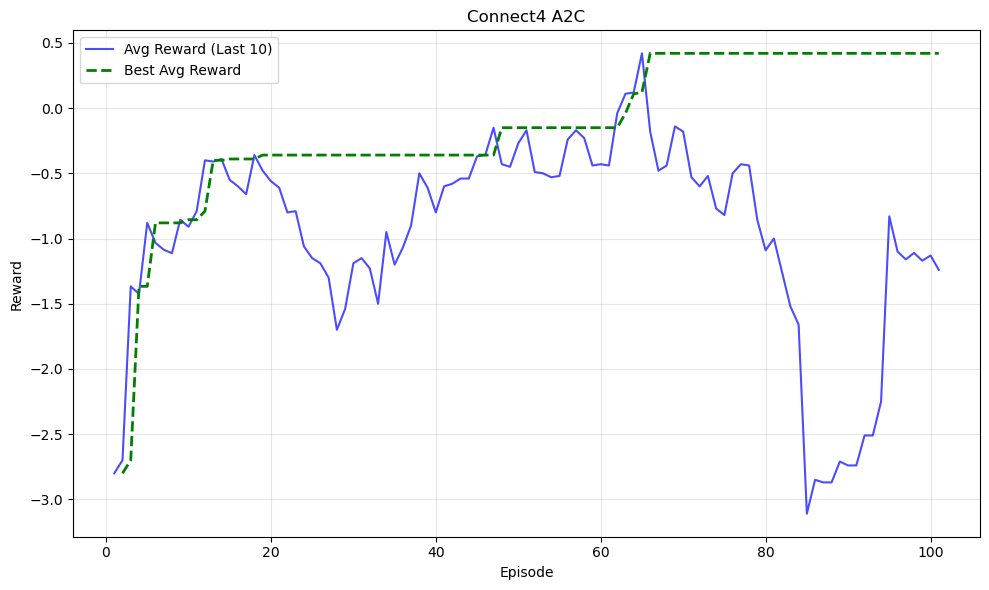

In [ ]:
import os
import pandas as pd
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from IPython.display import Image, display

log_file = rf"training_log.csv"
df = pd.read_csv(log_file)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Avg Reward (Last 10)
ax.plot(df['episode'], df['avg_reward_10'], label='Avg Reward (Last 10)', color='blue', alpha=0.7)

# Plot Best Avg Reward
ax.plot(df['episode'], df['best_reward'], label='Best Avg Reward', color='green', linestyle='--', linewidth=2)

ax.set_title(f"Connect4 A2C")
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

plot_path = "training_plot.png"
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
plt.close(fig)

print(f"Plot saved")

matplotlib.use('module://matplotlib_inline.backend_inline')
display(Image(plot_path))
